In [1]:
import pandas as pd
import os
from scipy import stats
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
import random
from datetime import datetime
import re
from dateutil.parser import parse
from matplotlib import dates

In [2]:
raw = '../data/raw/'

In [3]:
#n = 125497040
#s = 10000
#skip = sorted(random.sample(range(1,n),n-s))

In [4]:
#train = pd.read_csv(raw + 'train.csv', skiprows = skip)
train = pd.read_csv(raw + 'train_subset.csv')

In [5]:
#train.to_csv(raw + 'train_subset.csv', index = False)

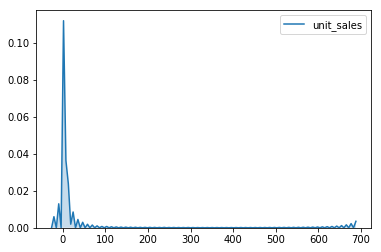

In [6]:
sns.kdeplot(train['unit_sales'], shade=True)

In [7]:
train.describe()

,id,store_nbr,item_nbr,unit_sales
count,1.000000e+04,10000.000000,1.000000e+04,10000.000000
mean,6.248034e+07,27.548800,9.642964e+05,8.552783
std,3.618078e+07,16.313155,5.196829e+05,18.079350
min,7.708000e+03,1.000000,1.035010e+05,-24.000000
25%,3.102337e+07,12.000000,5.179050e+05,2.000000
50%,6.189766e+07,28.000000,9.492980e+05,4.000000
75%,9.420538e+07,43.000000,1.351227e+06,9.000000
max,1.254970e+08,54.000000,2.116416e+06,686.000000


In [8]:
panel1 = train[train['unit_sales'] <= 0]
temp = train[train['unit_sales'] <= 2000]
panel2 = temp[temp['unit_sales'] >= -2000]

In [9]:
temp = train[train['unit_sales'] <= 25]
panel3 = temp[temp['unit_sales'] >= -5]

In [10]:
panel4 = train[train['unit_sales'] >= 600]

/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5,1,'High Sales')

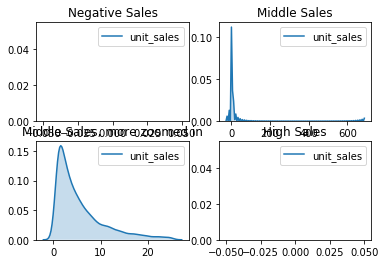

In [11]:
f, ax = plt.subplots(2,2)
sns.kdeplot(panel1['unit_sales'], shade=True, ax = ax[0][0]).set_title('Negative Sales')
sns.kdeplot(panel2['unit_sales'], shade=True, ax = ax[0][1]).set_title('Middle Sales')
sns.kdeplot(panel3['unit_sales'], shade=True, ax = ax[1][0]).set_title('Middle Sales, more zoomed in')
sns.kdeplot(panel4['unit_sales'], shade=True, ax = ax[1][1]).set_title('High Sales')

Bottom line, the unit sales data are highly non-normal. Both very high kurtosis and positive skew.

And of course they aren't "really" continuous since you can't sell .5 of a product!

There also seems to be a weird effect where at very high or very negative numbers only "nice round numbers" are being reported (e.g., spike at 15000, 10000...)

Note also, there are some negative sales and very high sales outside of the random sample that was selected

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119341a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11c0fdbe0>]], dtype=object)

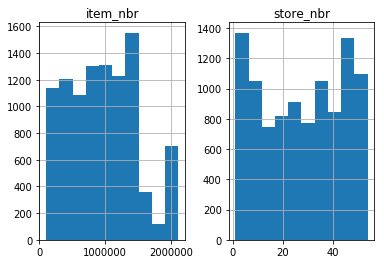

In [12]:
train.hist(column = ['item_nbr', 'store_nbr'])

In [13]:
onpro = train.onpromotion.value_counts()

[None, None, None, None]

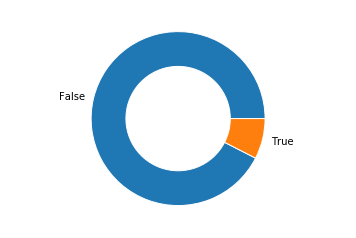

In [14]:
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(onpro.values, radius=1, labels=onpro.keys())
plt.setp(mypie, width=0.4, edgecolor='white')

Some items come up more often than others, as do some stores, but no particular pattern.

Way fewer items are on promotion than not.

In [15]:
items = pd.read_csv(raw + 'items.csv')

In [16]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [17]:
family_counts = items.family.value_counts()

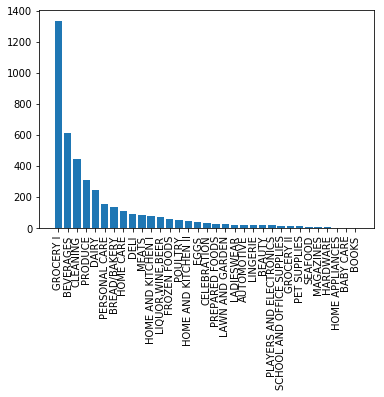

In [18]:
y_pos = np.arange(len(family_counts))
plt.bar(y_pos, family_counts.values)
plt.xticks(y_pos, family_counts.keys(), rotation = 90)
plt.show()

In [19]:
items.columns = ['item_nbr', 'family', 'class_', 'perishable']

In [20]:
#do family and class mean the same thing?
count_table = pd.DataFrame(columns = family_counts.keys(), index = items.class_.unique(), data = 0)

for i in range(0, len(items) -1):
    count_table[items['family'][i]][items['class_'][i]] += 1
    
count_table
#no family and class do not mean the same thing, because then there would only be numbers along
#the diagonal!
#however, there is only one nonzero value per row, in other words a family can contain many
#many classes, but a class cannot be part of multiple families

,GROCERY I,BEVERAGES,CLEANING,PRODUCE,DAIRY,PERSONAL CARE,BREAD/BAKERY,HOME CARE,DELI,MEATS,...,PLAYERS AND ELECTRONICS,SCHOOL AND OFFICE SUPPLIES,GROCERY II,PET SUPPLIES,SEAFOOD,MAGAZINES,HARDWARE,HOME APPLIANCES,BABY CARE,BOOKS
1093,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1067,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3008,0,0,26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1028,48,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2712,0,0,0,0,0,0,17,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1045,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1034,98,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1044,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1092,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1032,65,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


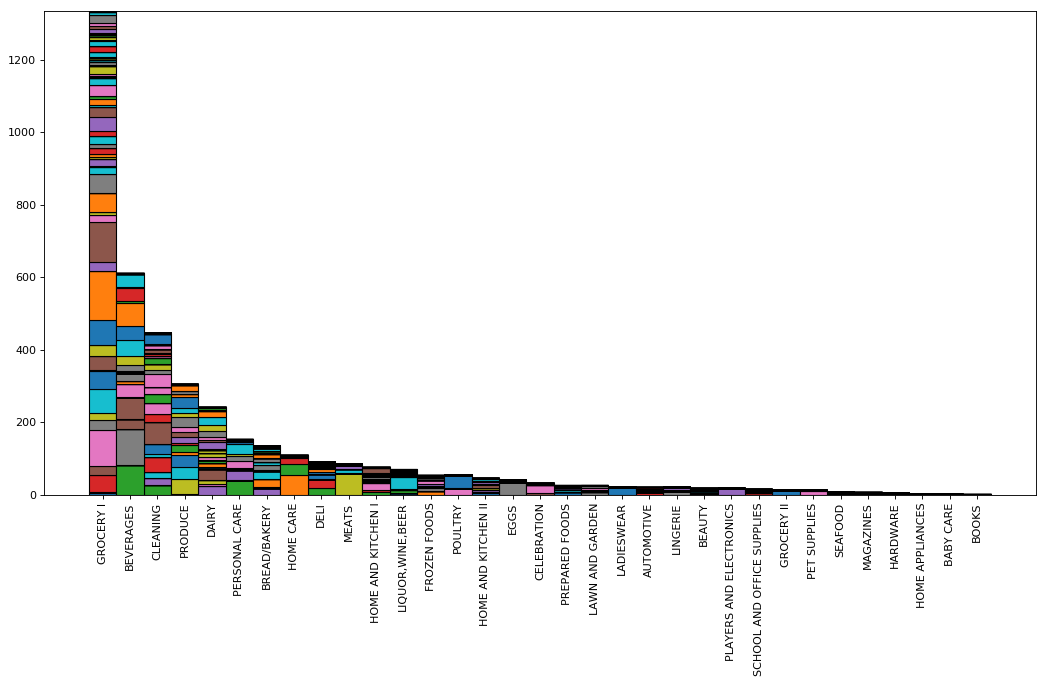

In [21]:
bars = ([0]*len(count_table.columns))
r = np.arange(len(count_table.columns))
names = count_table.columns
plt.figure(figsize=(16,8), dpi = 80)

for i in np.arange(len(count_table)):
    plt.bar(r, count_table.iloc[i][:].values, edgecolor = 'black', bottom = bars, width = 1)
    bars = bars + count_table.iloc[i][:].values

plt.xticks(y_pos, family_counts.keys(), rotation = 90)
plt.show()

In [22]:
#some classes are more common than others, smaller families for the most part have fewer classes
#all makes pretty good sense!

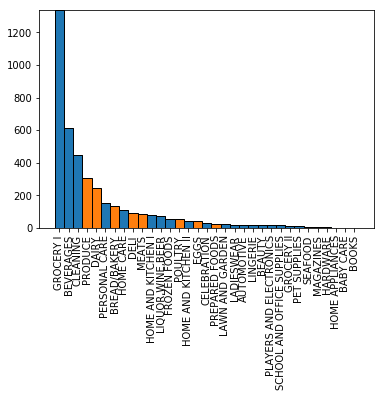

In [23]:
count_perish = pd.DataFrame(columns = family_counts.keys(), index = items.perishable.unique(), data = 0)

for i in range(0, len(items) -1):
    count_perish[items['family'][i]][items['perishable'][i]] += 1
    
#stacked bar graph, how many perishable in each family?
bars = ([0]*len(count_perish.columns))
r = np.arange(len(count_perish.columns))
names = count_perish.columns
#plt.figure(figsize=(16,8), dpi = 80)

for i in np.arange(len(count_perish)):
    plt.bar(r, count_perish.iloc[i][:].values, edgecolor = 'black', bottom = bars, width = 1)
    bars = bars + count_perish.iloc[i][:].values

plt.xticks(y_pos, family_counts.keys(), rotation = 90)
plt.show()

In [24]:
count_perish

,GROCERY I,BEVERAGES,CLEANING,PRODUCE,DAIRY,PERSONAL CARE,BREAD/BAKERY,HOME CARE,DELI,MEATS,...,PLAYERS AND ELECTRONICS,SCHOOL AND OFFICE SUPPLIES,GROCERY II,PET SUPPLIES,SEAFOOD,MAGAZINES,HARDWARE,HOME APPLIANCES,BABY CARE,BOOKS
0,1334,613,446,0,0,153,0,108,0,0,...,17,15,14,14,0,6,4,1,1,1
1,0,0,0,306,242,0,134,0,91,84,...,0,0,0,0,8,0,0,0,0,0


So major takeways...
* a given family is either perishable or not
* a class can only belong to one family
* family and perishable may be redundant with class, though I could imagine perishability having a big influence, but would modelling perishability explictly be silly if we already model class so that variability will be sucked up by class

In [25]:
holidays = pd.read_csv(raw + 'holidays_events.csv')

In [26]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [27]:
holitype = holidays.type.value_counts()

[None, None, None, None, None, None, None, None, None, None, None, None]

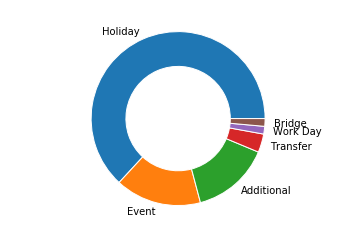

In [28]:
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(holitype.values, radius=1, labels=holitype.keys())
plt.setp(mypie, width=0.4, edgecolor='white')

In [29]:
locale_counts = holidays.locale.value_counts()

locale_count_table = pd.DataFrame(columns = locale_counts.keys(), index = holidays.locale_name.unique(), data = 0)

for i in range(0, len(holidays) -1):
    locale_count_table[holidays['locale'][i]][holidays['locale_name'][i]] += 1
    
locale_count_table

,National,Local,Regional
Manta,0,6,0
Cotopaxi,0,0,6
Cuenca,0,7,0
Libertad,0,6,0
Riobamba,0,12,0
Puyo,0,6,0
Guaranda,0,12,0
Imbabura,0,0,6
Latacunga,0,12,0
Machala,0,6,0


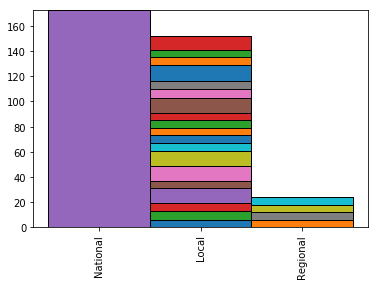

In [30]:
#again, locale_name can only belong to one locale (national, local, or regional), but locale's 
#have multiple locale names

#stacked bar graph, how many perishable in each family?
bars = ([0]*len(locale_count_table.columns))
r = np.arange(len(locale_count_table.columns))
names = locale_count_table.columns
#plt.figure(figsize=(16,8), dpi = 80)

for i in np.arange(len(locale_count_table)):
    plt.bar(r, locale_count_table.iloc[i][:].values, edgecolor = 'black', bottom = bars, width = 1)
    bars = bars + locale_count_table.iloc[i][:].values

plt.xticks(r, locale_count_table.columns, rotation = 90)
plt.show()

In [31]:
holitrans = holidays.transferred.value_counts()

[None, None, None, None]

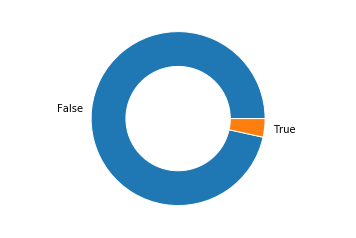

In [32]:
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(holitrans.values, radius=1, labels=holitrans.keys())
plt.setp(mypie, width=0.4, edgecolor='white')

In [33]:
type_table = pd.DataFrame(columns = holitype.keys(), index = holitrans.keys(), data = 0)

for i in range(0, len(holidays) -1):
    type_table[holidays['type'][i]][holidays['transferred'][i]] += 1
    
type_table

,Holiday,Event,Additional,Transfer,Work Day,Bridge
False,209,56,50,12,5,5
True,12,0,0,0,0,0


In [34]:
#okay, only holidays can be transferred, also, transfers are quite rare

In [35]:
oil = pd.read_csv(raw + 'oil.csv')

In [36]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [37]:
oil['date_as_datetime'] = [parse(x) for x in oil.date]

In [38]:
oil['date_as_num'] = [dates.date2num(x) for x in oil.date_as_datetime]

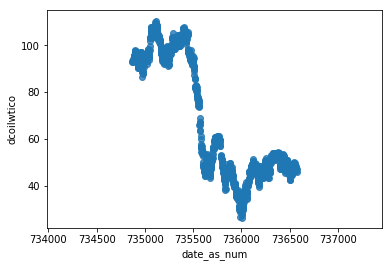

In [39]:
sns.regplot(oil['date_as_num'],oil['dcoilwtico'], fit_reg = False)

In [40]:
stores = pd.read_csv(raw + 'stores.csv')

In [41]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [42]:
#okay, it's certainly safe to assume that each city can only be in one state, but each state has
#multiple cities; but what do "type" and "cluster" mean?
stores.columns = ['store_nbr', 'city', 'state', 'store_type', 'cluster']

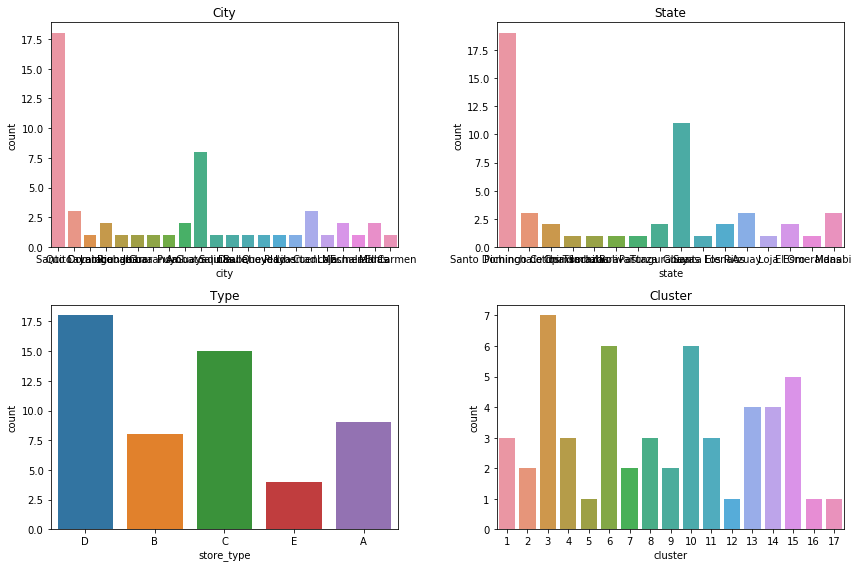

In [43]:
f, ax = plt.subplots(2,2)
sns.countplot(stores.city, ax = ax[0][0]).set_title('City')
sns.countplot(stores.state, ax = ax[0][1]).set_title('State')
sns.countplot(stores.store_type, ax = ax[1][0]).set_title('Type')
sns.countplot(stores.cluster, ax = ax[1][1]).set_title('Cluster')
f.tight_layout(rect = [0,1,2,3])

In [44]:
store_type_counts = stores.store_type.value_counts()

store_type_table = pd.DataFrame(columns = store_type_counts.keys(), index = stores.city.unique(), data = 0)

for i in range(0, len(stores) -1):
    store_type_table[stores['store_type'][i]][stores['city'][i]] += 1
    
store_type_table

,D,C,A,B,E
Quito,7,2,6,3,0
Santo Domingo,1,1,0,1,0
Cayambe,0,0,0,1,0
Latacunga,0,2,0,0,0
Riobamba,0,1,0,0,0
Ibarra,0,1,0,0,0
Guaranda,0,1,0,0,0
Puyo,0,1,0,0,0
Ambato,1,0,1,0,0
Guayaquil,2,2,1,1,2


In [45]:
cluster_counts = stores.cluster.value_counts()

cluster_table = pd.DataFrame(columns = cluster_counts.keys(), index = stores.city.unique(), data = 0)

for i in range(0, len(stores) -1):
    cluster_table[stores['cluster'][i]][stores['city'][i]] += 1
    
cluster_table

,3,6,10,15,14,13,1,11,8,4,2,9,7,5,16,12,17
Quito,0,2,0,1,3,3,0,2,3,0,0,1,0,1,1,1,0
Santo Domingo,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Cayambe,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Latacunga,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
Riobamba,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Ibarra,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Guaranda,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Puyo,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Ambato,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
Guayaquil,2,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [46]:
#wow, some cities (e.g., El Carmen) have no clusters

In [47]:
cluster_type = stores.cluster.value_counts()

cluster_type_table = pd.DataFrame(columns = cluster_counts.keys(), index = stores.store_type.unique(), data = 0)

for i in range(0, len(stores) -1):
    cluster_type_table[stores['cluster'][i]][stores['store_type'][i]] += 1
    
cluster_type_table

,3,6,10,15,14,13,1,11,8,4,2,9,7,5,16,12,17
D,0,0,1,0,0,4,3,0,3,3,2,2,0,0,0,0,0
B,0,6,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
C,6,0,0,5,0,0,0,0,0,0,0,0,2,0,0,1,0
E,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A,0,0,0,0,4,0,0,3,0,0,0,0,0,1,0,0,1


In [48]:
#almost all clusters have only one type, the exception is cluster 10 which has multiple types

In [49]:
transactions = pd.read_csv(raw + 'transactions.csv')

In [50]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [51]:
transactions['date_datetime']=[parse(x) for x in transactions.date]

In [52]:
transactions['date_num']=[dates.date2num(x) for x in transactions.date_datetime]

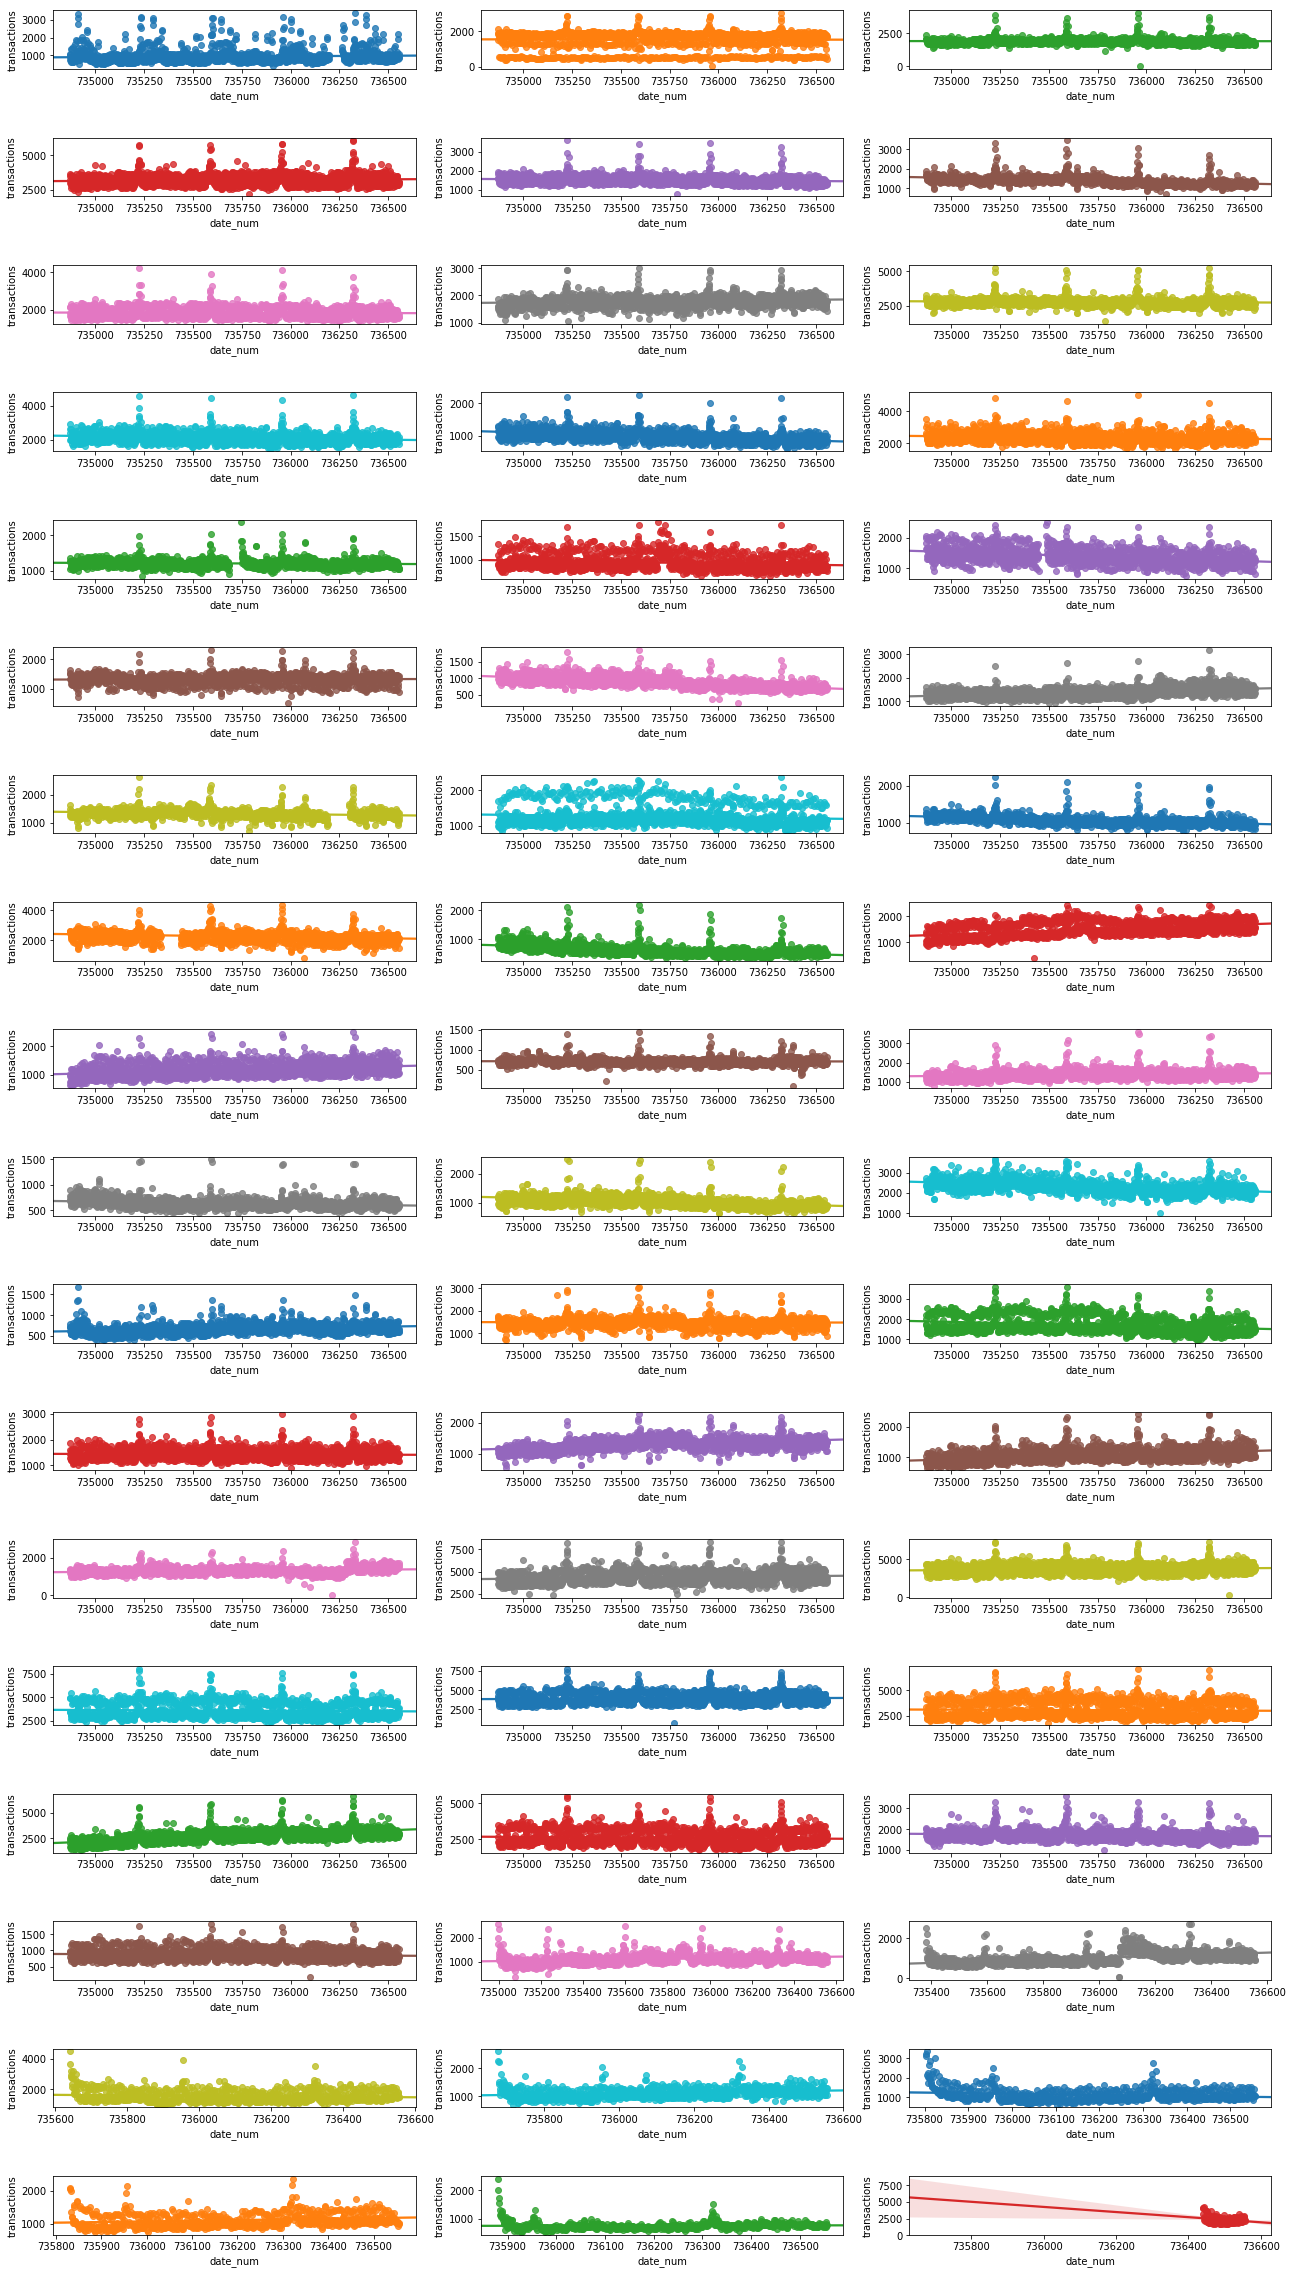

In [53]:
f, ax = plt.subplots(18,3)

row = 0
column = 0

for i in transactions.store_nbr.unique():
    sns.regplot(transactions[transactions.store_nbr == i]['date_num'], 
                transactions[transactions.store_nbr == i]['transactions'],
                ax = ax[column][row])
    row +=1
    if row == 3:
        row = 0
        column += 1
        
f.tight_layout(rect = [0,0,3,8])    

In [54]:
#what columns does test have?
test = pd.read_csv(raw + 'test.csv')

In [55]:
test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [56]:
train_datetime = [parse(x) for x in train['date']]
test_datetime = [parse(x) for x in test['date']]



In [57]:
print('Min Train: ', min(train_datetime))
print('Max Train: ', max(train_datetime))

Min Train:  2013-01-02 00:00:00
Max Train:  2017-08-15 00:00:00


In [58]:
print('Min Test: ', min(test_datetime))
print('Max Test: ', max(test_datetime))

Min Test:  2017-08-16 00:00:00
Max Test:  2017-08-31 00:00:00


In [59]:
print('Max Oil: ', max(oil.date_as_datetime))

Max Oil:  2017-08-31 00:00:00


In [60]:
#organized by date, may only want to call the last 10,000 (rather than a random subset) for training
#likely that more recent information is more relevant, though oil is going up-ish